In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

After importing necessary libraries, we next import the training dataset

In [2]:
data=pd.read_csv('C:\\Users\\Akshita Puri\\Desktop\\project\\dmpa\\mbti_1.csv')
data=data.iloc[0:5000,:]
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


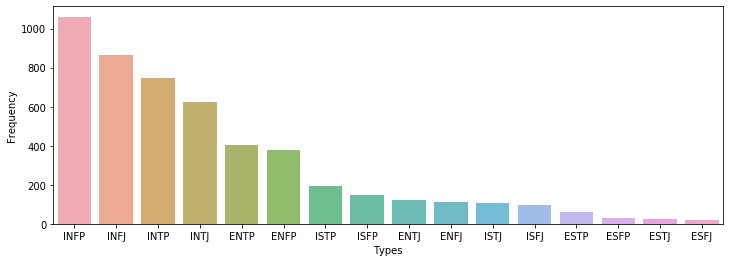

In [3]:
cnt_types=data['type'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_types.index,cnt_types.values,alpha=0.8)
plt.ylabel('Frequency')
plt.xlabel('Types')
plt.show()

In [36]:
import re

# Data Preprocessing

This particular function below is required to encode the personality type combinations into binary format. It is then applied to the training dataset.

In [37]:
def get_types(row):
    t=row['type']
    I=0;N=0
    T=0;J=0
    if(t[0]=='I'):
        I=1
    elif(t[0]=='E'):
        I=0
    else:
        print('IE incorrect')
    if(t[1]=='N'):
        N=1
    elif(t[1]=='S'):
        N=0
    else:
        print('NS incorrect')
        
    if(t[2]=='T'):
        T=1
    elif(t[2]=='F'):
        T=0
    else:
        print('TF incorrect')
    if(t[3]=='J'):
        J=1
    elif(t[3]=='P'):
        J=0
    else:
        print('JP incorrect')
    
    return pd.Series({'IE':I,'NS':N,'TF':T,'JP':J})

data=data.join(data.apply(lambda row: get_types(row),axis=1))
data.head()

,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1


A simple correlation matrix in order to remove if there are any dependent personality types. This is not a necessary step but useful in getting insight of the data.

In [38]:
data[['IE','NS','TF','JP']].corr()

,IE,NS,TF,JP
IE,1.000000,-0.031347,-0.079885,0.169806
NS,-0.031347,1.000000,-0.088525,0.020528
TF,-0.079885,-0.088525,1.000000,-0.020733
JP,0.169806,0.020528,-0.020733,1.000000


These 2 functions are used to retrieve the personality type from binary format and vice versa.

In [39]:
b_pers={'I':0,'E':1,'N':0,'S':1,'F':0,'T':1,'J':0,'P':1}
b_persList=[{0:'I',1:'E'},{0:'N',1:'S'},{0:'F',1:'T'},{0:'J',1:'P'}]
def translate_pers(personal):
    return[b_pers[l] for l in personal]
def translate_back(person):
    s=""
    for i,l in enumerate(person):
        s+=b_persList[i][l]
    return s

The following python libraries are quitessential for sentiment analysis.
PorterStemmer is used for stemming which implies that all the the words are converted to their root words in order to extravicate the same meaning. For eg: the root word for studied, studying and studies will be study.
Stopwords are used to remove the short words like 'is','an','was' etc which particularly do not hold any context.
Tokenize is to convert the text into a list of words without the stopwords.

In [40]:
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize

Since we will also be dealing with tweets which involve content like emoticons, hastags,various non textual symbols, below is a function which takes care of removal of all such irrelvant information. Yes emoticons can be decoded as well and they may provide some information but they would have negligible reflection on personality.
The re library handles all the regular expressions for removal.

In [41]:
unique_type_list=['infj','entp','intp','intj','entj','enfj','infp','enfp','isfp','istp','isfj','istj','estp','esfp','estj','esfj']
stemmer=PorterStemmer()
lemmatizer=WordNetLemmatizer()
sw=stopwords.words('english')
def pre_process(data,remove_stop_words=True,remove_mbti_profiles=True):
    personality=[]
    post=[]
    len_data=len(data)
    i=0
    
    for row in data.iterrows():
        pos=row[1].posts
        temp=re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-@._&+]|(?:[0-9a-fA-F][0-9a-fA-F]))+',' ',pos)
        temp=re.sub("^[a-zA-Z]"," ",temp)
        temp=re.sub(' +',' ',temp).lower()
        if remove_stop_words:
            temp=" ".join([lemmatizer.lemmatize(w) for w in temp.split(' ') if w not in sw])
        else:
            temp=" ".join([lemmatizer.lemmatize(w) for w in temp.split(' ')])
        
        
                
        type_labelized=translate_pers(row[1].type)
        personality.append(type_labelized)
        post.append(temp)
    post=np.array(post)
    personality=np.array(personality)
    return post,personality
    

In [42]:
list_posts,list_personality=pre_process(data,remove_stop_words=True)

Tf-Idf is an important concept when dealing with textual data. It has some simple math behind it but the utility is, in simple words, to obtain words which are low in frequency ie the ones which provide the context.


In [43]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

In [44]:
counter=CountVectorizer(analyzer="word",max_features=1500,tokenizer=None,max_df=0.7,min_df=0.1)
x_cnt=counter.fit_transform(list_posts)
tf=TfidfTransformer()
x_tfidf=tf.fit_transform(x_cnt).toarray()

In [45]:
features=list(enumerate(counter.get_feature_names()))


In [46]:
type_indicators=["IE:Introversion(I)/Extroversion(E)","NS:Intuition(N)-Sensing(S)","FT:Feeling(F)-Thinking(T)","JP:Judging(J)-Perceiving(P)"]


# Model Fitting

The model we have worked on is that using XGboost which is derived from Gradient Boost.
Gradient boost has a lot of depth to it but as of now we have used it for classification. Here,in XGBoost, a number of classification trees are built with parameters like learning rate and regularization added to simple gradient boost which need to be tuned to obtain optimum results.



The model will be trained from the training set imported earlier and then it will be used to predict the personality type of a user from Twitter using their tweets.

In [48]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


Starting below, we have illustrated how we keep adding paramters to our model in order to build it.
First, we started with basic XGBoostClassifier and obtained an accuracy score via testing on 20% of the training data.

In [49]:
X=x_tfidf
acc=[]
for l in range(len(type_indicators)):
    print(type_indicators[l],'....')
    Y=list_personality[:,l]
    
    x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.33,random_state=42)
    model=XGBClassifier()
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    predictions=[round(value) for value in y_pred]
    accuracy=accuracy_score(y_test,predictions)
    
    print(accuracy*100.0)

    

IE:Introversion(I)/Extroversion(E) ....
84.72727272727273
NS:Intuition(N)-Sensing(S) ....
90.24242424242425
FT:Feeling(F)-Thinking(T) ....
83.75757575757575
JP:Judging(J)-Perceiving(P) ....
80.36363636363636


Next, we added a few more parameters to increase the learning efficiency of the model.  

In [50]:
for l in range(len(type_indicators)):
    print(type_indicators[l],'....')
    Y=list_personality[:,l]
    
    x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.33,random_state=42)
    model=XGBClassifier()
    eval_set=[(x_test,y_test)]
    model.fit(x_train,y_train,early_stopping_rounds=10,eval_metric="logloss",eval_set=eval_set,verbose=True)
    y_pred=model.predict(x_test)
    predictions=[round(value) for value in y_pred]
    accuracy=accuracy_score(y_test,predictions)
    print(accuracy*100.0)

IE:Introversion(I)/Extroversion(E) ....
[0]	validation_0-logloss:0.56550
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.49741
[2]	validation_0-logloss:0.45314
[3]	validation_0-logloss:0.42912
[4]	validation_0-logloss:0.41004
[5]	validation_0-logloss:0.39831
[6]	validation_0-logloss:0.38906
[7]	validation_0-logloss:0.37488
[8]	validation_0-logloss:0.36990
[9]	validation_0-logloss:0.36266
[10]	validation_0-logloss:0.36050
[11]	validation_0-logloss:0.35886
[12]	validation_0-logloss:0.35595
[13]	validation_0-logloss:0.35565
[14]	validation_0-logloss:0.35449
[15]	validation_0-logloss:0.35264
[16]	validation_0-logloss:0.34927
[17]	validation_0-logloss:0.34896
[18]	validation_0-logloss:0.34998
[19]	validation_0-logloss:0.35107
[20]	validation_0-logloss:0.35079
[21]	validation_0-logloss:0.34884
[22]	validation_0-logloss:0.34836
[23]	validation_0-logloss:0.34841
[24]	validation_0-logloss:0.34909
[25]	validation_0-logloss:0.34939
[26]	validation_0-

We observe a slight variation in the accuracy scores between the two models.
Next, we will bring in our tweets obtained using RapidMiner to test our model.

In [51]:
tweets=pd.read_csv('C:\\Users\\Akshita Puri\\Desktop\\project\\dmpa\\TomCruise_cleanedT.csv')

In [52]:
tweets.head()

,ID,Text
0,0,Summer #TopGun https AABKxnEDv
1,1,Warning Real flying Real forces make puke #Top...
2,2,#TopGun https vdhTtXb
3,3,Feel need Trailer tomorrow #TopGun https rWHfK...
4,4,Thank fans came Hall today great share first t...


In [53]:
tweet=' '.join(tweets.Text)

Here, an initial value needs to be assigned for XGBoost to form a tree. This initial value keeps getting corrected as the model proceeds while creating trees. Hence, we have assigned any random personality type to the user tweets.

In [54]:
final_t=pd.DataFrame(data={'type':'INFJ','posts':[tweet]})

Tweets will also require data cleaning

In [55]:
tweet,dummy=pre_process(final_t,remove_stop_words=True)

We will also find the contextual words in tweets to compare with our training set and that is the basis for tree formation.

In [56]:
t_x_cnt=counter.transform(tweet)

t_x_tfidf=tf.transform(t_x_cnt).toarray()

# Fitting the model and Predicting

In [57]:
param={}
param['n_parameters']=200
param['max_depth']=2
param['n_thread']=8
param['learning_rate']=0.2

result=[]
for l in range(len(type_indicators)):
    print(type_indicators[l],'....')
    Y=list_personality[:,l]
    
    x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.33,random_state=42)
    model=XGBClassifier(**param)
    model.fit(x_train,y_train)
    y_pred=model.predict(t_x_tfidf)
    result.append(y_pred[0])


IE:Introversion(I)/Extroversion(E) ....
NS:Intuition(N)-Sensing(S) ....
FT:Feeling(F)-Thinking(T) ....
JP:Judging(J)-Perceiving(P) ....


In [58]:
translate_back(result)

'INFP'